In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_3/data_day_6'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_3/data_day_6


In [ ]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [ ]:
sc = SparkContext(master="local", appName="New Spark Context")
spark = SparkSession(sc)

In [ ]:
df = spark.read.csv("5000_points.txt", header=False, inferSchema=True, sep='\t')
df.show(5)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
|618600|551446|
|635690|608046|
+------+------+
only showing top 5 rows



In [ ]:
df = df.select(col('_c0').alias('x'), col('_c1').alias('y'))
df.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['x', 'y'], outputCol='features')
final_df = assembler.transform(df)

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)
scaler_fit = scaler.fit(final_df)
final_df = scaler_fit.transform(final_df)
final_df.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaled_features                        |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

k_means_result = []
for k in range(2, 11):
    # fit model
    k_means = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = k_means.fit(final_df)

    # compute wsse
    wsse = model.computeCost(final_df)

    # Compute silhouette
    predictions = model.transform(final_df)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)

    k_means_result.append((k, wsse, silhouette))
    print('With k = {}, Sum of Squared Error = {:.4f}, silhouette = {:.4f}'.format(k, wsse, silhouette))
k_means_result = pd.DataFrame(k_means_result, columns=['k', 'wsse', 'silhouette'])

With k = 2, Sum of Squared Error = 6378.9715, silhouette = 0.4905
With k = 3, Sum of Squared Error = 3762.8270, silhouette = 0.5638
With k = 4, Sum of Squared Error = 2406.3317, silhouette = 0.6147
With k = 5, Sum of Squared Error = 1817.0452, silhouette = 0.6172
With k = 6, Sum of Squared Error = 1409.0244, silhouette = 0.6377
With k = 7, Sum of Squared Error = 1104.9435, silhouette = 0.6774
With k = 8, Sum of Squared Error = 1010.5119, silhouette = 0.6726
With k = 9, Sum of Squared Error = 804.1815, silhouette = 0.6710
With k = 10, Sum of Squared Error = 644.0803, silhouette = 0.6907


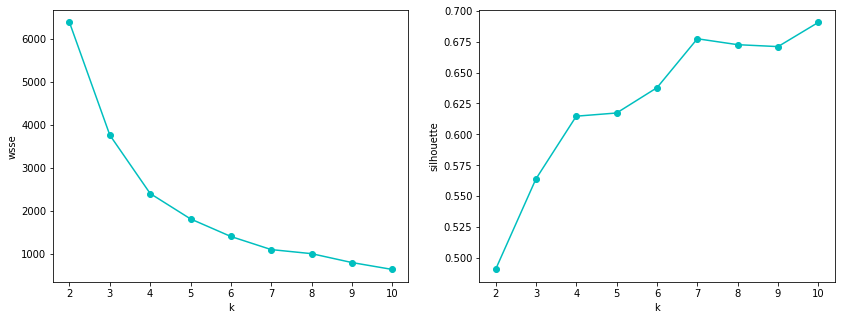

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(k_means_result['k'], k_means_result['wsse'], 'co-')
plt.xlabel('k')
plt.ylabel('wsse')

plt.subplot(1,2,2)
plt.plot(k_means_result['k'], k_means_result['silhouette'], 'co-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.show()

In [ ]:
# Select k = 7
k = 7
k_means = KMeans(featuresCol='scaled_features', k=k, seed=42)
model = k_means.fit(final_df)

# compute wsse
wsse = model.computeCost(final_df)

# Compute silhouette
predictions = model.transform(final_df)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print('With k = {}, Sum of Squared Error = {:.4f}, silhouette = {:.4f}'.format(k, wsse, silhouette))

With k = 7, Sum of Squared Error = 1104.9435, silhouette = 0.6774


In [ ]:
predictions.show(10)

+------+------+-------------------+--------------------+----------+
|     x|     y|           features|     scaled_features|prediction|
+------+------+-------------------+--------------------+----------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...|         5|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|         5|
|597173|575538|[597173.0,575538.0]|[2.44276602706395...|         5|
|618600|551446|[618600.0,551446.0]|[2.53041424234143...|         5|
|635690|608046|[635690.0,608046.0]|[2.60032174218239...|         5|
|588100|557588|[588100.0,557588.0]|[2.40565246673294...|         5|
|582015|546191|[582015.0,546191.0]|[2.38076146986154...|         5|
|604678|574577|[604678.0,574577.0]|[2.47346560496368...|         5|
|572029|518313|[572029.0,518313.0]|[2.33991323736231...|         5|
|604737|574591|[604737.0,574591.0]|[2.47370694741486...|         5|
+------+------+-------------------+--------------------+----------+
only showing top 10 rows



In [ ]:
predictions.groupBy('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1030|
|         1|  662|
|         2|  643|
|         3|  701|
|         4|  653|
|         5|  929|
|         6|  382|
+----------+-----+



In [ ]:
predictions.show(3)

+------+------+-------------------+--------------------+----------+
|     x|     y|           features|     scaled_features|prediction|
+------+------+-------------------+--------------------+----------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...|         5|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|         5|
|597173|575538|[597173.0,575538.0]|[2.44276602706395...|         5|
+------+------+-------------------+--------------------+----------+
only showing top 3 rows



In [ ]:
predictions = predictions.withColumn('x_scaled', predictions['features'].getItem(0))
predictions.show(3)

In [ ]:
predictions_df = predictions.select('scaled_features', 'prediction').toPandas()
predictions_df

,scaled_features,prediction
0,"[2.716775610700365, 2.336092297255214]",5
1,"[2.7236722780340017, 2.3658538924649704]",5
2,"[2.4427660270639544, 2.440366004250274]",5
3,"[2.5304142423414357, 2.3382123709986073]",5
4,"[2.6003217421823916, 2.5782047187507375]",5
...,...,...
4995,"[2.7219583375756424, 3.6208315448666792]",6
4996,"[2.829952948652358, 3.663330543126743]",6
4997,"[2.661561366531072, 3.6518991055023657]",6
4998,"[2.4528860478133123, 3.6410231271987574]",6
